### I've created this notebook as this is my first object detection challenge and thus wanted to explore image augmentation when each image has multiple bounding boxes and labels. Sharing this publicly as this might be useful to beginners like me.

In [1]:
import os
import ast
from collections import namedtuple

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm
from PIL import Image

import joblib
from joblib import Parallel, delayed

import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations.bbox_utils import denormalize_bbox, normalize_bbox

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imsave

In [2]:
# Constants
BASE_DIR = '/kaggle/input/global-wheat-detection'
WORK_DIR = '/kaggle/working'

# Set seed for numpy for reproducibility
np.random.seed(1996)

In [3]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))

# Let's expand the bounding box coordinates and calculate the area of all the bboxes
train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
train_df['area'] = train_df['width'] * train_df['height']
train_df['x_max'] = train_df['x_min'] + train_df['width']
train_df['y_max'] = train_df['y_min'] + train_df['height']
train_df = train_df.drop(['bbox', 'source'], axis=1)
train_df = train_df[['image_id', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height', 'area']]

# There are some buggy annonations in training images having huge bounding boxes. Let's remove those bboxes
train_df = train_df[train_df['area'] < 100000]

train_df.head()

image_id  x_min  y_min  x_max  y_max  width  height     area
0  b6ab77fd7  834.0  222.0  890.0  258.0   56.0    36.0   2016.0
1  b6ab77fd7  226.0  548.0  356.0  606.0  130.0    58.0   7540.0
2  b6ab77fd7  377.0  504.0  451.0  664.0   74.0   160.0  11840.0
3  b6ab77fd7  834.0   95.0  943.0  202.0  109.0   107.0  11663.0
4  b6ab77fd7   26.0  144.0  150.0  261.0  124.0   117.0  14508.0

In [4]:
print(train_df.shape)

(147769, 8)


In [5]:
image_ids = train_df['image_id'].unique()
print(f'Total number of training images: {len(image_ids)}')

Total number of training images: 3373


There are two major formats of bounding boxes:

1. **pascal_voc**, which is [x_min, y_min, x_max, y_max]
2. **COCO**, which is [x_min, y_min, width, height]

We'll see how to perform image augmentations for both the formats. Let's first start with **pascal_voc** format.

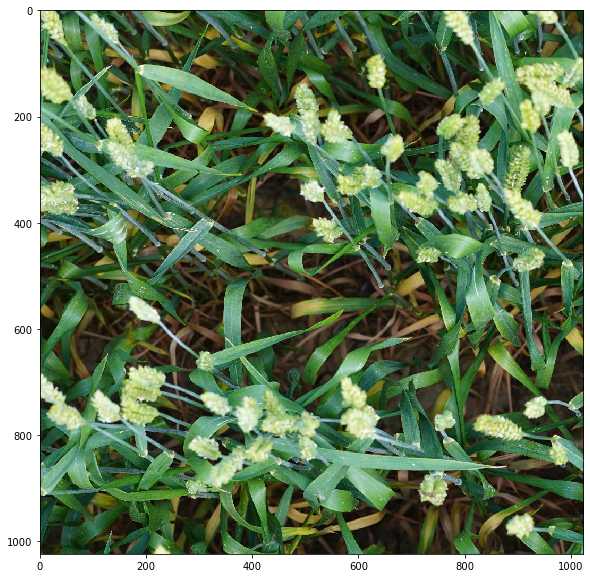

In [6]:
# Read the image on which data augmentaion is to be performed
image_id = 'c14c1e300'
image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.figure(figsize = (10, 10))
plt.imshow(image)
plt.show()

We've our image ready, let's create an array of bounding boxes for all the wheat heads in the above image and the array of labels (we've only 2 class here: wheat head and background). As all bounding boxes are of same class, labels array will contain only 1's. 

In [7]:
pascal_voc_boxes = train_df[train_df['image_id'] == image_id][['x_min', 'y_min', 'x_max', 'y_max']].astype(np.int32).values
coco_boxes = train_df[train_df['image_id'] == image_id][['x_min', 'y_min', 'width', 'height']].astype(np.int32).values
assert(len(pascal_voc_boxes) == len(coco_boxes))
labels = np.ones((len(pascal_voc_boxes), ))

Let's plot the bounding boxes on the above image

In [8]:
def get_bbox(bboxes, col, color='white', bbox_format='pascal_voc'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        if bbox_format == 'pascal_voc':
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2] - bboxes[i][0], 
                bboxes[i][3] - bboxes[i][1], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')
        else:
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2], 
                bboxes[i][3], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

Let's define augmentations using albumentations library. We will define a single verticle flip with probability 1 for re-producibility.

In [9]:
aug = albumentations.Compose([
        albumentations.Resize(512, 512),   # Resize the given 1024 x 1024 image to 512 * 512
        albumentations.VerticalFlip(1),    # Verticlly flip the image
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [10]:
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)

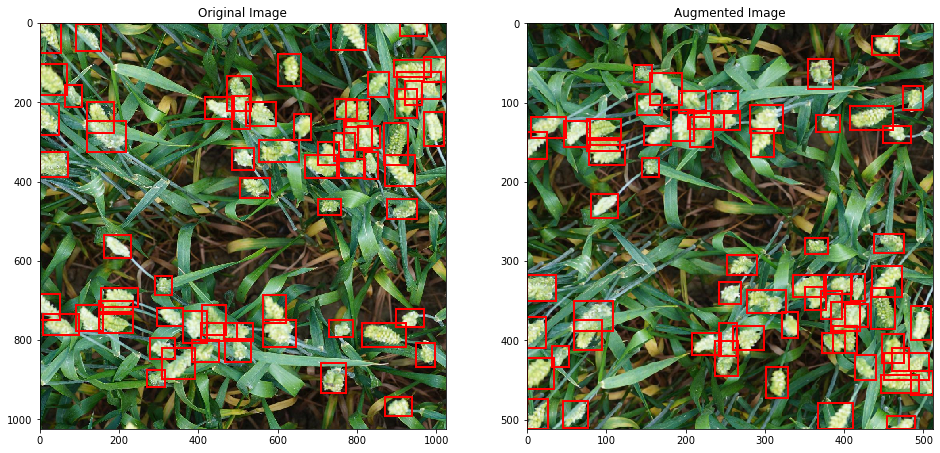

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()

As you can see in above images, we resized the image to half of the original size and also vertically flipped the image. All the bounding boxes are also transformed accordingly.  

Let's now do the same with COCO bounding box format.

In [12]:
aug = albumentations.Compose([
        albumentations.Resize(512, 512),   # Resize the given 1024 x 1024 image to 512 * 512
        albumentations.VerticalFlip(1),     # Verticlly flip the image
        albumentations.Blur(p=1)
    ], bbox_params={'format': 'coco', 'label_fields': ['labels']})

In [13]:
aug_result = aug(image=image, bboxes=coco_boxes, labels=labels)

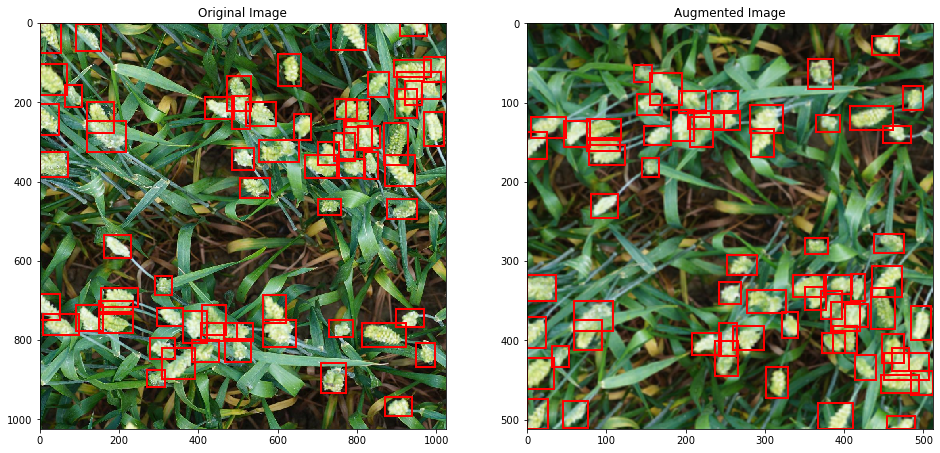

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(coco_boxes, ax[0], color='red', bbox_format='coco')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red', bbox_format='coco')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()

## Edit: After learning a few augmentations techniques with albumentations, I'm implementing custom random cutout augmentation with handling of bounding boxes.

Note: We will use original image size and poscal VOC format for bboxes. Also will create a augmented dataset with new images instead of augmenting images on the fly while training.

## Let's define new augmentations

Using augmentation library we will perform following augmentations (which also takes care of bounding boxes coordinates)
* Horizontal Flip
* Vertical Flip
* Blur
* Adding GaussNoise
* Cutout (Custom implementation to handle bounding boxes)

In [15]:
class CustomCutout(DualTransform):
    """
    Custom Cutout augmentation with handling of bounding boxes 
    Note: (only supports square cutout regions)
    
    Author: Kaushal28
    """
    
    def __init__(
        self,
        fill_value=0,
        bbox_removal_threshold=0.50,
        min_cutout_size=192,
        max_cutout_size=512,
        always_apply=False,
        p=0.5
    ):
        """
        Class construstor
        
        :param fill_value: Value to be filled in cutout (default is 0 or black color)
        :param bbox_removal_threshold: Bboxes having content cut by cutout path more than this threshold will be removed
        :param min_cutout_size: minimum size of cutout (192 x 192)
        :param max_cutout_size: maximum size of cutout (512 x 512)
        """
        super(CustomCutout, self).__init__(always_apply, p)  # Initialize parent class
        self.fill_value = fill_value
        self.bbox_removal_threshold = bbox_removal_threshold
        self.min_cutout_size = min_cutout_size
        self.max_cutout_size = max_cutout_size
        
    def _get_cutout_position(self, img_height, img_width, cutout_size):
        """
        Randomly generates cutout position as a named tuple
        
        :param img_height: height of the original image
        :param img_width: width of the original image
        :param cutout_size: size of the cutout patch (square)
        :returns position of cutout patch as a named tuple
        """
        position = namedtuple('Point', 'x y')
        return position(
            np.random.randint(0, img_width - cutout_size + 1),
            np.random.randint(0, img_height - cutout_size + 1)
        )
        
    def _get_cutout(self, img_height, img_width):
        """
        Creates a cutout pacth with given fill value and determines the position in the original image
        
        :param img_height: height of the original image
        :param img_width: width of the original image
        :returns (cutout patch, cutout size, cutout position)
        """
        cutout_size = np.random.randint(self.min_cutout_size, self.max_cutout_size + 1)
        cutout_position = self._get_cutout_position(img_height, img_width, cutout_size)
        return np.full((cutout_size, cutout_size, 3), self.fill_value), cutout_size, cutout_position
        
    def apply(self, image, **params):
        """
        Applies the cutout augmentation on the given image
        
        :param image: The image to be augmented
        :returns augmented image
        """
        image = image.copy()  # Don't change the original image
        self.img_height, self.img_width, _ = image.shape
        cutout_arr, cutout_size, cutout_pos = self._get_cutout(self.img_height, self.img_width)
        
        # Set to instance variables to use this later
        self.image = image
        self.cutout_pos = cutout_pos
        self.cutout_size = cutout_size
        
        image[cutout_pos.y:cutout_pos.y+cutout_size, cutout_pos.x:cutout_size+cutout_pos.x, :] = cutout_arr
        return image
    
    def apply_to_bbox(self, bbox, **params):
        """
        Removes the bounding boxes which are covered by the applied cutout
        
        :param bbox: A single bounding box coordinates in pascal_voc format
        :returns transformed bbox's coordinates
        """

        # Denormalize the bbox coordinates
        bbox = denormalize_bbox(bbox, self.img_height, self.img_width)
        x_min, y_min, x_max, y_max = tuple(map(int, bbox))

        bbox_size = (x_max - x_min) * (y_max - y_min)  # width * height
        overlapping_size = np.sum(
            (self.image[y_min:y_max, x_min:x_max, 0] == self.fill_value) &
            (self.image[y_min:y_max, x_min:x_max, 1] == self.fill_value) &
            (self.image[y_min:y_max, x_min:x_max, 2] == self.fill_value)
        )

        # Remove the bbox if it has more than some threshold of content is inside the cutout patch
        if overlapping_size / bbox_size > self.bbox_removal_threshold:
            return normalize_bbox((0, 0, 0, 0), self.img_height, self.img_width)

        return normalize_bbox(bbox, self.img_height, self.img_width)

    def get_transform_init_args_names(self):
        """
        Fetches the parameter(s) of __init__ method
        :returns: tuple of parameter(s) of __init__ method
        """
        return ('fill_value')

In [16]:
augmentation = albumentations.Compose([
    CustomCutout(p=1),
    albumentations.Flip(always_apply=True), # Either Horizontal, Vertical or both flips
    albumentations.OneOf([  # One of blur or adding gauss noise
        albumentations.Blur(p=0.50),  # Blurs the image
        albumentations.GaussNoise(var_limit=5.0 / 255.0, p=0.50)  # Adds Gauss noise to image
    ], p=1)
], bbox_params = {
    'format': 'pascal_voc',
    'label_fields': ['labels']
})

## TODO: Will add more augmentations after checking how this affects the results. Stay Tuned!

## Plotting a few images with and without augmentations

In [17]:
def get_bbox(bboxes, col, color='white'):
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (bboxes[i][0], bboxes[i][1]),
            bboxes[i][2] - bboxes[i][0], 
            bboxes[i][3] - bboxes[i][1], 
            linewidth=2, 
            edgecolor=color, 
            facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)

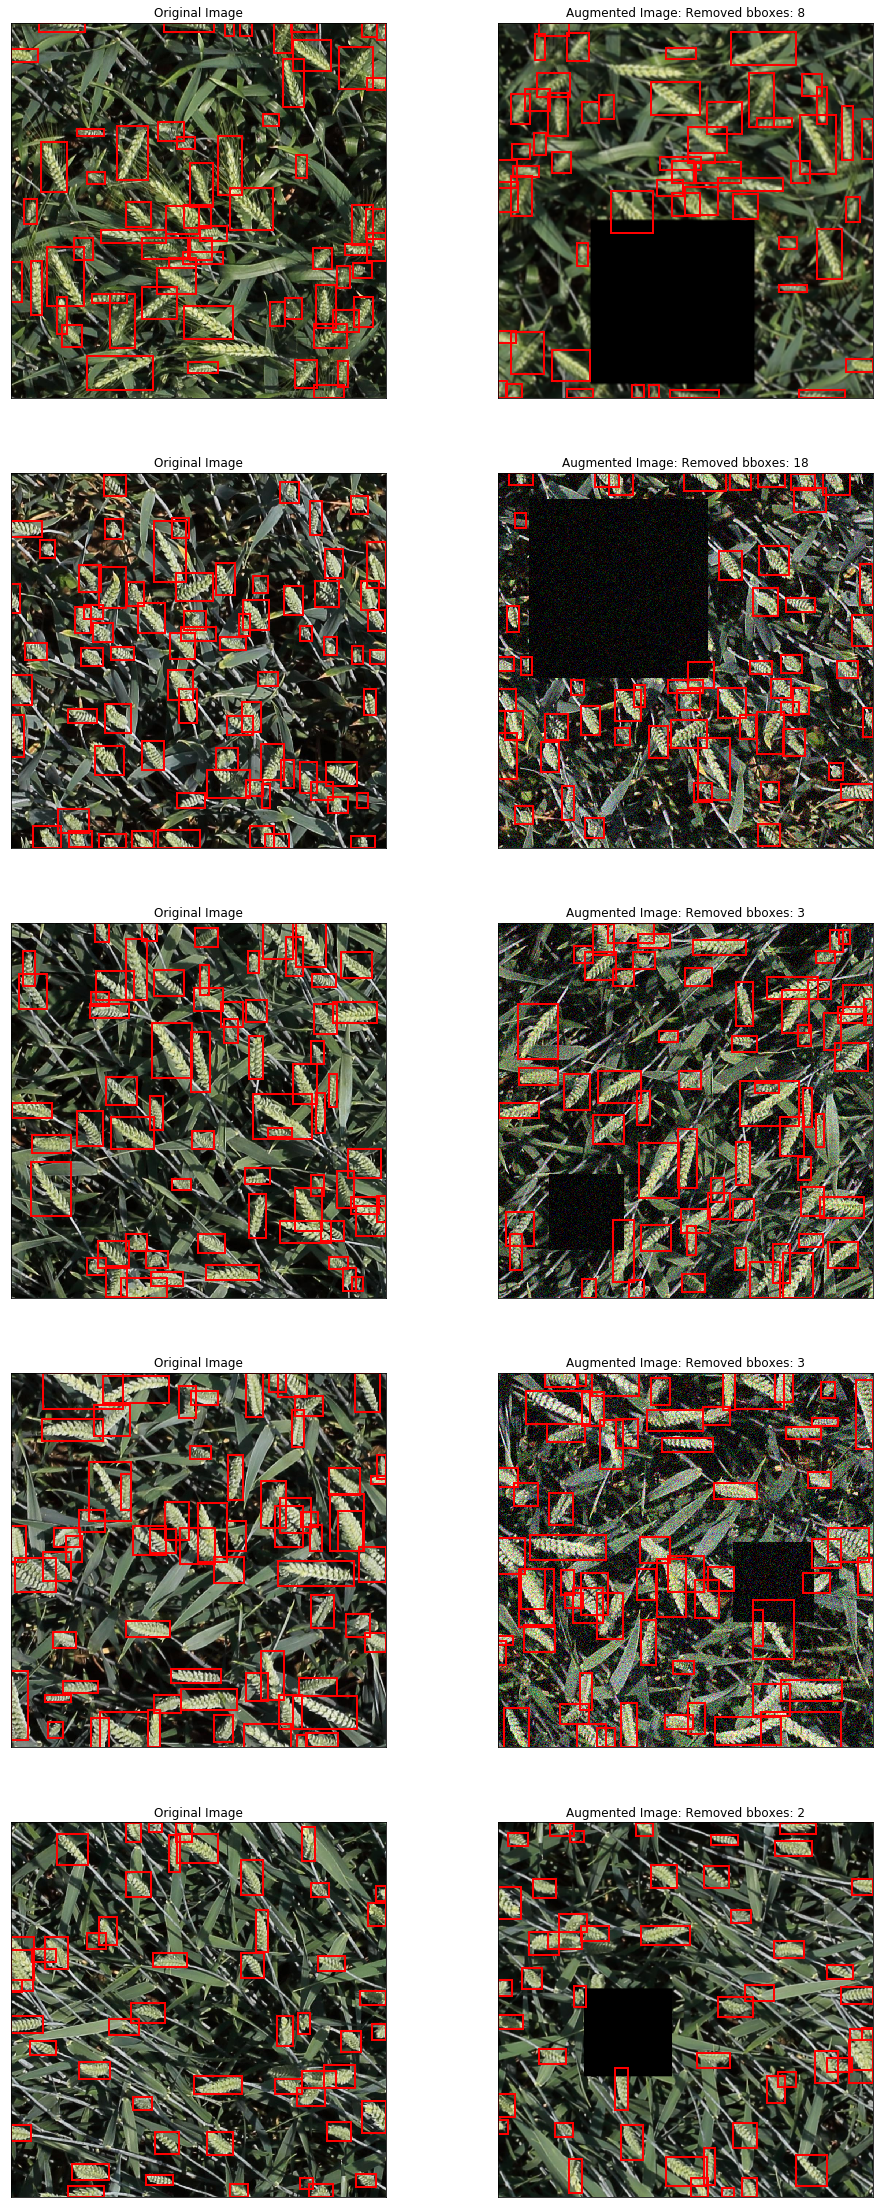

In [18]:
num_images = 5
rand_start = np.random.randint(0, len(image_ids) - 5)
fig, ax = plt.subplots(nrows=num_images, ncols=2, figsize=(16, 40))
for index, image_id in enumerate(image_ids[rand_start : rand_start + num_images]):
    # Read the image from image id
    image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0  # Normalize
    
    # Get the bboxes details and apply all the augmentations
    bboxes = train_df[train_df['image_id'] == image_id][['x_min', 'y_min', 'x_max', 'y_max']].astype(np.int32).values
    labels = np.ones((len(bboxes), ))  # As we have only one class (wheat heads)
    aug_result = augmentation(image=image, bboxes=bboxes, labels=labels)

    get_bbox(bboxes, ax[index][0], color='red')
    ax[index][0].grid(False)
    ax[index][0].set_xticks([])
    ax[index][0].set_yticks([])
    ax[index][0].title.set_text('Original Image')
    ax[index][0].imshow(image)

    get_bbox(aug_result['bboxes'], ax[index][1], color='red')
    ax[index][1].grid(False)
    ax[index][1].set_xticks([])
    ax[index][1].set_yticks([])
    ax[index][1].title.set_text(f'Augmented Image: Removed bboxes: {len(bboxes) - len(aug_result["bboxes"])}')
    ax[index][1].imshow(aug_result['image'])
plt.show()

## Now let's apply this augmentations to entire dataset and create a larger dataset

In [19]:
augmentation = albumentations.Compose([
    CustomCutout(p=0.50),
    albumentations.Flip(always_apply=True), # Either Horizontal, Vertical or both flips
    albumentations.OneOf([  # One of blur or adding gauss noise
        albumentations.Blur(p=0.50),  # Blurs the image
        albumentations.GaussNoise(var_limit=5.0 / 255.0, p=0.50)  # Adds Gauss noise to image
    ], p=1)
], bbox_params = {
    'format': 'pascal_voc',
    'label_fields': ['labels']
})

In [20]:
if not os.path.isdir('train'):
    os.mkdir('train')

In [21]:
def create_dataset(index, image_id):
    # Read the image from image id
    image = cv2.imread(os.path.join(BASE_DIR, 'train', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the bboxes details and apply all the augmentations
    bboxes = train_df[train_df['image_id'] == image_id][['x_min', 'y_min', 'x_max', 'y_max']].astype(np.int32).values
    labels = np.ones((len(bboxes), ))  # As we have only one class (wheat heads)
    aug_result = augmentation(image=image, bboxes=bboxes, labels=labels)

    aug_image = aug_result['image']
    aug_bboxes = aug_result['bboxes']
    
    Image.fromarray(image).save(os.path.join(WORK_DIR, 'train', f'{image_id}.jpg'))
    Image.fromarray(aug_image).save(os.path.join(WORK_DIR, 'train', f'{image_id}_aug.jpg'))

    image_metadata = []
    for bbox in aug_bboxes:
        bbox = tuple(map(int, bbox))
        image_metadata.append({
            'image_id': f'{image_id}_aug',
            'x_min': bbox[0],
            'y_min': bbox[1],
            'x_max': bbox[2],
            'y_max': bbox[3],
            'width': bbox[2] - bbox[0],
            'height': bbox[3] - bbox[1],
            'area': (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
        })
    return image_metadata

In [22]:
image_metadata = Parallel(n_jobs=8)(delayed(create_dataset)(index, image_id) for index, image_id in tqdm(enumerate(image_ids), total=len(image_ids)))
image_metadata = [item for sublist in image_metadata for item in sublist]

100%|██████████| 3373/3373 [06:45<00:00,  8.32it/s]


In [23]:
aug_train_df = pd.DataFrame(image_metadata)
aug_train_df.head()

image_id  x_min  y_min  x_max  y_max  width  height   area
0  b6ab77fd7_aug    134    222    190    258     56      36   2016
1  b6ab77fd7_aug     81     95    190    202    109     107  11663
2  b6ab77fd7_aug    874    144    998    261    124     117  14508
3  b6ab77fd7_aug    890    602    972    647     82      45   3690
4  b6ab77fd7_aug     15    220     71    323     56     103   5768

In [24]:
print(aug_train_df.shape)

(139134, 8)


In [25]:
train_df = pd.concat([train_df, aug_train_df])
train_df

image_id  x_min  y_min  x_max   y_max  width  height     area
0           b6ab77fd7  834.0  222.0  890.0   258.0   56.0    36.0   2016.0
1           b6ab77fd7  226.0  548.0  356.0   606.0  130.0    58.0   7540.0
2           b6ab77fd7  377.0  504.0  451.0   664.0   74.0   160.0  11840.0
3           b6ab77fd7  834.0   95.0  943.0   202.0  109.0   107.0  11663.0
4           b6ab77fd7   26.0  144.0  150.0   261.0  124.0   117.0  14508.0
...               ...    ...    ...    ...     ...    ...     ...      ...
139129  5e0747034_aug   90.0  290.0  172.0   384.0   82.0    94.0   7708.0
139130  5e0747034_aug  876.0  310.0  960.0   405.0   84.0    95.0   7980.0
139131  5e0747034_aug  749.0  725.0  890.0   796.0  141.0    71.0  10011.0
139132  5e0747034_aug  410.0  932.0  594.0  1011.0  184.0    79.0  14536.0
139133  5e0747034_aug   55.0  223.0  149.0   284.0   94.0    61.0   5734.0

[286903 rows x 8 columns]

In [26]:
train_df.shape

(286903, 8)

In [27]:
train_df.to_csv('train.csv', index=False)

In [28]:
!zip -r -qq train.zip train
!rm -rf train